In [230]:
## NEW AND CLEAN NOTEBOOK, FINAL

In [231]:
!pip install pandas matplotlib datetime yfinance numpy scipy scikit-learn pandas_market_calendars numpy pycopula



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [232]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as DT
import yfinance as yf
import numpy as np 
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import pandas_market_calendars as mcal
import datetime
import scipy as sp
import scipy.interpolate
from scipy.stats import norm
import math

import numpy as np
import pandas as pd
from scipy.stats import t, norm
from pycopula.copula import GaussianCopula

## Data Import

In [233]:
final_date = pd.to_datetime('2024-09-26')
start_date = pd.to_datetime('2024-01-01')
dt=1/252

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data = data.dropna(subset=['Log Return'])
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

common_dates = list(set(stoxx50.index).intersection(set(smi.index).intersection(set(sp500.index))))
## losing data on dates, simulation also assuming common dates, losing about 14% data
print("Data Loss:", (3*len(common_dates))/(len(stoxx50)+len(smi)+len(sp500)))

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data = data[data.index.isin(common_dates)]
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(-1))
    data.drop(columns=["Change %"], errors = "Ignore", inplace = True)
    data = data.dropna(subset=['Log Return'])
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)


chf = pd.read_csv("../Data CSV/USD_CHF Historical Data.csv")
chf.index = pd.DatetimeIndex(chf["Date"])
eur = pd.read_csv("../Data CSV/USD_EUR Historical Data.csv")
eur.index = pd.DatetimeIndex(eur["Date"])

stoxx50['Price'] = (stoxx50['Price']/eur['Price']).dropna()
stoxx50['Log Return'] = np.log(stoxx50['Price'] / stoxx50['Price'].shift(1))
smi['Price'] = (smi['Price']/chf['Price']).dropna()
smi['Log Return'] = np.log(smi['Price'] / smi['Price'].shift(1))

returns = pd.DataFrame({
    'SMI': smi['Log Return'],
    'STOXX50': stoxx50['Log Return'],
    'SP500': sp500['Log Return']
}).dropna()

final_date =  pd.to_datetime('2024-09-26')

dates = pd.bdate_range(start=start_date,end=final_date)

interest_rates = pd.read_excel("../Data CSV/US Interest Rates.xlsx")
interest_rates.columns = interest_rates.columns.str.strip()
interest_rates = interest_rates.dropna(subset=["United States Treasury 10-YR Rates"])
interest_rates["United States Treasury 10-YR Rates"] = pd.to_numeric(
    interest_rates["United States Treasury 10-YR Rates"], errors="coerce"
)
interest_rates.index = pd.DatetimeIndex(interest_rates["Dates"])
full_date_range = pd.date_range(start=interest_rates.index.min(), end=interest_rates.index.max())
interest_rates = interest_rates.reindex(full_date_range).ffill()
interest_rates.index.name = "Dates"
interest_rates.head()
r = interest_rates["United States Treasury 10-YR Rates"].dropna()*0.01
print(r)

sp500_init_level = 3977
stoxx_init_level_local = 4164
smi_init_level_local = 10786


Data Loss: 0.8628979857050032
Dates
2019-11-12    0.0192
2019-11-13    0.0188
2019-11-14    0.0182
2019-11-15    0.0184
2019-11-16    0.0184
               ...  
2024-11-04    0.0431
2024-11-05    0.0426
2024-11-06    0.0442
2024-11-07    0.0431
2024-11-08    0.0430
Freq: D, Name: United States Treasury 10-YR Rates, Length: 1824, dtype: float64


In [234]:
def price_barrier_reverse_convertible(start_date, price_paths ):
    final_date = pd.to_datetime('2024-09-26')
    start_date = pd.to_datetime(start_date)    
    T = (final_date - start_date).days / 365.0

    eur_usd = eur["Price"][start_date] 
    chf_usd = chf["Price"][start_date] 
    stoxx_init_level = stoxx_init_level_local / eur_usd
    smi_init_level = smi_init_level_local / chf_usd

    
    sp500_barrier = sp500_init_level * 0.65
    stoxx_barrier = stoxx_init_level * 0.65
    smi_barrier = smi_init_level * 0.65
    
    payment_dates = [start_date + pd.DateOffset(months=3*i) for i in range(1, 5)]
    payment_dates = [d for d in payment_dates if d <= final_date]
    
    risk_free_rate = r[r.index <= start_date].iloc[-1]
    
    pv_interest = sum([
        1000 * 0.025 * math.exp(-risk_free_rate * ((payment_date - start_date).days / 365.0))
        for payment_date in payment_dates
    ])
    
    discount_factor_maturity = math.exp(-risk_free_rate * T)
    
    sim_dates = pd.bdate_range(start=start_date, end=final_date)
    sim_length = len(sim_dates)
    
    num_sims = len(price_paths['SMI'])
    
    prices = np.zeros(num_sims)
    
    for i in range(num_sims):
        sim_SMI = np.array(price_paths['SMI'][i][:sim_length])
        sim_SP500 = np.array(price_paths['SP500'][i][:sim_length])
        sim_STOXX50 = np.array(price_paths['STOXX50'][i][:sim_length])
        
        barrier_breached = (
            (sim_SMI < smi_barrier).any() or
            (sim_SP500 < sp500_barrier).any() or
            (sim_STOXX50 < stoxx_barrier).any()
        )
        
        if not barrier_breached:
            pv_redemption = 1000 * discount_factor_maturity
        else:
            final_SMI = sim_SMI[-1]
            final_SP500 = sim_SP500[-1]
            final_STOXX50 = sim_STOXX50[-1]
            
            perf_SMI = final_SMI / smi_init_level
            perf_SP500 = final_SP500 / sp500_init_level
            perf_STOXX50 = final_STOXX50 / stoxx_init_level
            
            worst_perf = min(perf_SMI, perf_SP500, perf_STOXX50, 1)
            pv_redemption = 1000 * discount_factor_maturity * worst_perf
        
        price = pv_interest + pv_redemption
        prices[i] = price
    
    return prices

## Different models

In [235]:
def simulate_gbm(start_date, n_simulations = 100000, verbose = False, h_percentage_change = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}):
    dt = 1 / 252  
    mu = {}
    sigma = {}
    
    risk_free_rate = r[r.index <= start_date].iloc[-1]
   
    # risk_free_rate = np.log(1+0.01*r[r.index <= start_date].iloc[-1])
    
    for index in ['SMI', 'STOXX50', 'SP500']:
        mean_return = risk_free_rate
        variance = returns[index].var()*252
        mu[index] = mean_return
        sigma[index] = np.sqrt(variance)
    
    corr_matrix = returns.corr()
    chol_matrix = np.linalg.cholesky(corr_matrix)
    
    n_timesteps = len(dates)
    
    Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
    Z_flat = Z.reshape(-1, 3)
    Z_correlated_flat = Z_flat @ chol_matrix.T
    Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)
    
    initial_prices = {
        'SMI': smi[smi.index >= start_date]['Price'].iloc[-1],
        'STOXX50': stoxx50[stoxx50.index >= start_date]['Price'].iloc[-1],
        'SP500': sp500[sp500.index >= start_date]['Price'].iloc[-1]
    }

    for i in initial_prices:
        initial_prices[i] *= h_percentage_change.get(i)
    
    price_paths = {
        'SMI': np.zeros((n_timesteps + 1, n_simulations)),
        'STOXX50': np.zeros((n_timesteps + 1, n_simulations)),
        'SP500': np.zeros((n_timesteps + 1, n_simulations))
    }
    
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index][0] = initial_prices[index]
    
    for i in range(1, n_timesteps + 1):
        for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
            drift_term = (mu[index] - 0.5 * sigma[index] ** 2)*dt
            diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
            price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)
    
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index]= price_paths[index].transpose()
    T = (final_date-start_date).days/352
    if not verbose:
        return price_paths
    
    print()
    for i in mu:
        print(i, "mu:", mu.get(i), "std:", sigma.get(i))
        print(i, "expected mu:", mu.get(i)*T, "std:", sigma.get(i)*np.sqrt(T))
        print()
    for i in price_paths:
        print(i)
        paths = price_paths.get(i)
        print("| Mean Price:", np.mean([i[-1] for i in paths]), "| Mean Return:", np.mean([i[-1] for i in paths])/paths[0][0], "| SD of Return:", np.std(np.array([i[-1] for i in paths])/paths[0][0]))
    return price_paths

In [ ]:
from scipy.optimize import minimize

def simulate_price_paths_with_CIR(start_date, n_simulations, h_percentage_change = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}):
    start_date = pd.to_datetime(start_date)
    final_date = pd.to_datetime('2024-09-26')
  
    price_data = {
        'SMI': smi,
        'STOXX50': stoxx50,
        'SP500': sp500
    }

    # Load exchange rate data
    exchange_rates = {
        'EURUSD': eur,
        'CHFUSD': chf
    }
    

    dt = 1 / 252 

    # Define the negative log-likelihood function. Here we fix theta to be 3.84%, according to US Long-Term Monthly Rate Analysis
    def negative_log_likelihood(params, r_df, theta=0.0384):
        kappa, sigma_r = params
        if kappa <= 0 or sigma_r <= 0:
            return np.inf
        log_likelihood = 0
        rates = r_df["United States Treasury 10-YR Rates"].values
        dates = r_df.index
        for t in range(len(rates) - 1):
            r_t = rates[t]
            r_t1 = rates[t + 1]
            dr = r_t1 - r_t
            dt_days = (dates[t + 1] - dates[t]).days
            dt = dt_days / 252
            if dt <= 0:
                continue
            mean_increment = kappa * (theta - r_t) * dt
            variance_increment = sigma_r**2 * r_t * dt
            if variance_increment <= 0:
                return np.inf
            likelihood_t = -0.5 * np.log(2 * np.pi * variance_increment) - 0.5 * (
                (dr - mean_increment) ** 2 / variance_increment
            )
            log_likelihood += likelihood_t
        return -log_likelihood
    
    print(r)

    initial_vals = [0.1, np.std(rates)]
    bounds = ((1e-5, None), (1e-5, None))

    result = minimize(
        negative_log_likelihood, initial_vals, args=(r,), bounds=bounds, method="L-BFGS-B"
    )
    kappa, sigma_r = result.x
    theta = 0.0384  # Fixed value

    sim_dates = pd.bdate_range(start=start_date, end=final_date)
    n_timesteps = len(sim_dates)
    indices = ['SMI', 'STOXX50', 'SP500']

    mu = {}
    sigma = {}
    for index in indices:
        mean_return = returns[index].mean()
        variance = returns[index].var()*252
        mu[index] = mean_return
        sigma[index] = np.sqrt(variance)  

    corr_matrix = returns[indices].corr()
    chol_matrix = np.linalg.cholesky(corr_matrix)

    Z = np.random.normal(size=(n_timesteps, n_simulations, len(indices)))
    Z_flat = Z.reshape(-1, len(indices))
    Z_correlated_flat = Z_flat @ chol_matrix.T
    Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, len(indices))
    initial_prices = {}
    for index in indices:
        initial_prices[index] = price_data[index]['Price'][price_data[index].index >= start_date].iloc[-1]

    for i in initial_prices:
        initial_prices[i] *= h_percentage_change.get(i)
        
    eur_usd = exchange_rates['EURUSD']['Price'].iloc[-1]
    chf_usd = exchange_rates['CHFUSD']['Price'].iloc[-1]
    initial_prices['STOXX50'] /= eur_usd
    initial_prices['SMI'] /= chf_usd
    
    price_paths = {
        index: np.zeros((n_simulations, n_timesteps + 1))
        for index in indices
    }
    for index in indices:
        price_paths[index][:, 0] = initial_prices[index]

    initial_rate =r[r.index >= start_date].iloc[0]
    r_paths = np.zeros((n_simulations, n_timesteps + 1))
    r_paths[:, 0] = initial_rate

    for i in range(1, n_timesteps + 1):
        Z_r = np.random.normal(size=n_simulations)
        r_t_prev = r_paths[:, i - 1]
        dr = kappa * (theta - r_t_prev) * dt + sigma_r * np.sqrt(np.maximum(r_t_prev, 0) * dt) * Z_r
        r_paths[:, i] = np.maximum(r_t_prev + dr, 0)
        
        for idx, index in enumerate(indices):
            drift_term = (np.log(1+0.01*r_paths[:, i]) - 0.5 * sigma[index] ** 2) * dt
            diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
            price_paths[index][:, i] = price_paths[index][:, i - 1] * np.exp(drift_term + diffusion_term)
    return price_paths, r_paths


In [237]:
def empirical_martingale_correction(price_data, r):
    price_data_new = {}
    
    for i in price_data:
        s = price_data.get(i)
        Z = np.zeros_like(s)
        s_ = np.zeros_like(s)
        s_[:,0] = s[:,0]
        r = np.log(1.03)
        for j in range(1, s.shape[1]):
            t_j = j * dt
            Z[:, j] = (s_[:, j-1] / s[:, j-1]) * s[:, j]
            Z_sum = np.average(Z[:, j], axis=0)
            Z0_j = np.exp(-r * t_j) * Z_sum
            s_[:, j] = s[:, 0] * Z[:, j] / Z0_j
        price_data_new[i] = s_
    return price_data_new
        

## Pricing

In [238]:
dates = pd.bdate_range(start = '2024-01-01', end = '2024-04-01')
price_chart = pd.DataFrame({"Start_Date":[], "GBM_Mean_Price":[], "GBM_Mean_Price_EMcorrection":[], "CIR_Mean_Price":[]})
for start_date in dates[:90]:
    nsim = 100
    price_paths = simulate_gbm(start_date, n_simulations= nsim)
    gbm = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
    price_paths = empirical_martingale_correction(price_paths, r[r.index == start_date])
    GBM_EMcorrection = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
    price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations= nsim)
    cir = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
    price_chart.loc[len(price_chart)+1] = {"Start_Date": start_date, "GBM_Mean_Price": np.mean(gbm), "GBM_Mean_Price_EMcorrection": np.mean(GBM_EMcorrection), "CIR_Mean_Price": np.mean(cir)}
    

KeyError: 'United States Treasury 10-YR Rates'

In [ ]:
price_chart

,Start_Date,GBM_Mean_Price,GBM_Mean_Price_EMcorrection,CIR_Mean_Price
1,2024-01-01,1021.090209,1021.090209,871.264128
2,2024-01-02,1020.681233,1020.681233,890.735335
3,2024-01-03,1021.078033,1021.078033,901.740849
4,2024-01-04,1020.600956,1020.600956,921.943751
5,2024-01-05,1020.273024,1020.273024,884.571853
...,...,...,...,...
62,2024-03-26,1028.058122,1028.058122,1010.364193
63,2024-03-27,1003.899366,1003.899366,994.386157
64,2024-03-28,1004.012043,1004.012043,997.937734
65,2024-03-29,1004.124733,1004.124733,994.266730


<Axes: xlabel='Start_Date'>

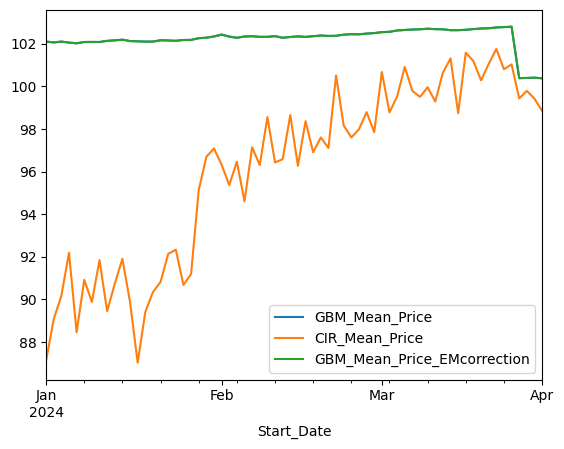

In [ ]:
price_chart.set_index('Start_Date', inplace = True)
price_chart *= 0.1
price_chart[["GBM_Mean_Price", "CIR_Mean_Price", "GBM_Mean_Price_EMcorrection"]].plot()

## Delta Calculation

In [ ]:
dates = pd.bdate_range(start = start_date, end = '2024-04-01')
delta_chart = pd.DataFrame({"Start_Date":[], "sp500_delta":[], "smi_delta":[], "stoxx50_delta":[]})
h = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}
for start_date in dates:
    nsim = 10000
    h = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}
    deltas = {}
    for i in h:
        h = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}
        h[i] = 1.05
        
        price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations= nsim, h_percentage_change= h)
        cir = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
        upper_price = np.mean(cir)
        
        h[i] = 0.95
        
        price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations= nsim, h_percentage_change= h)
        cir = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
        lower_price = np.mean(cir)

        deltas[i] = (upper_price-lower_price)/10

    delta_chart.loc[len(delta_chart)+1] = {"Start_Date": start_date, 
                                           "sp500_delta":deltas.get("SP500"), 
                                           "smi_delta":deltas.get("SMI"), 
                                           "stoxx50_delta":deltas.get("STOXX50")}
    

<Axes: xlabel='Start_Date'>

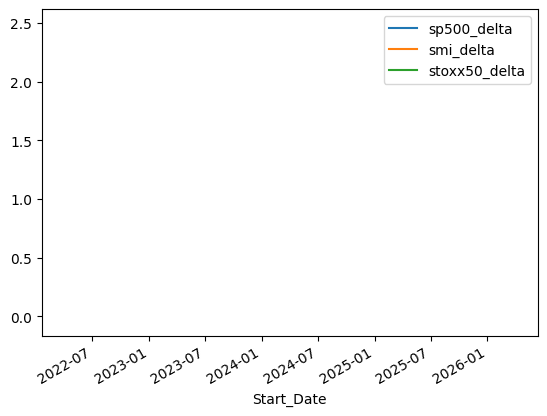

In [ ]:
delta_chart.set_index("Start_Date", inplace = True)
delta_chart.plot()